Processing AAPL...


[*********************100%***********************]  1 of 1 completed


Fold 1...


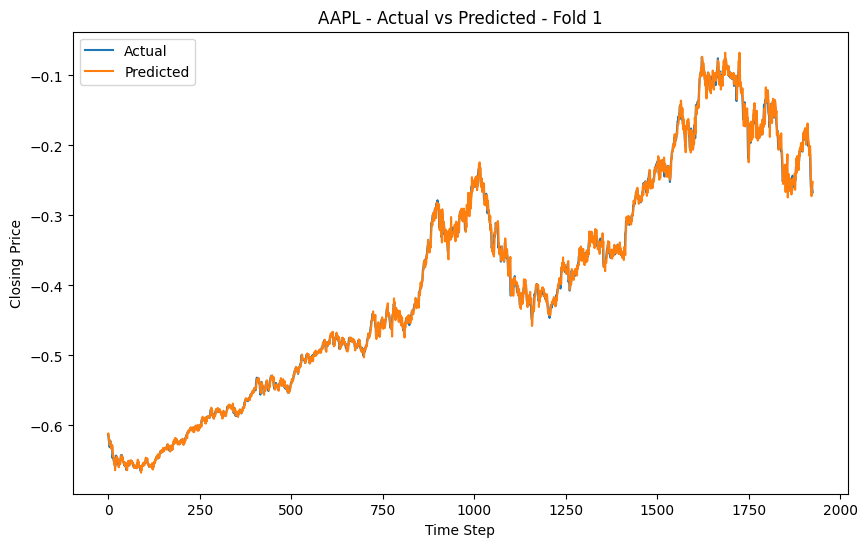

Fold 2...


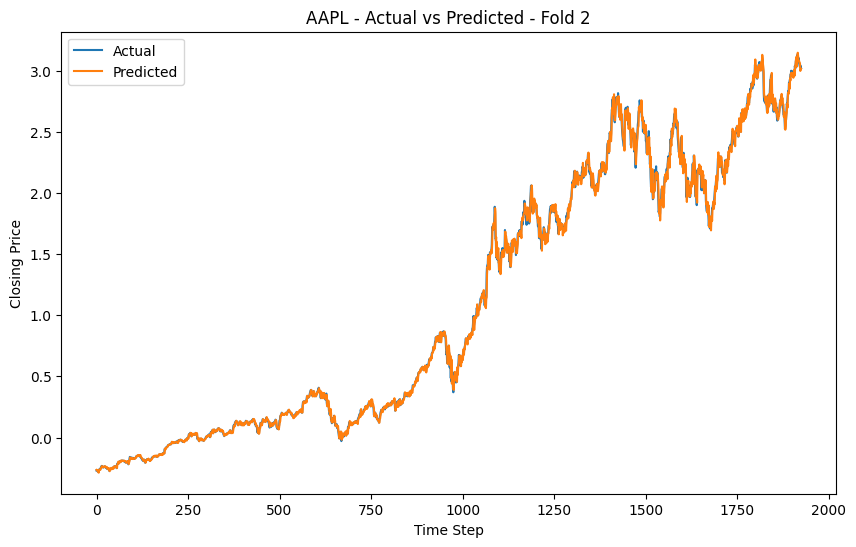

[*********************100%***********************]  1 of 1 completed

Next Day's Predicted Price for AAPL on 2023-12-30: 190.90218816126387

Summary of Linear Regression Performance for AAPL:
  Ticker  Fold       MSE       MAE  R2 Score      MAPE
0   AAPL     1  0.000058  0.005315  0.997814  0.021272
1   AAPL     2  0.001700  0.026602  0.998526  0.114335

Overall Metrics for AAPL:
Mean Squared Error: 0.0008790457053916544
Mean Absolute Error: 0.015958243839209643
R2 Score: 0.9992351777335743
Mean Absolute Percentage Error (MAPE): 0.06780359457700798
Processing TSLA...


Fold 1...


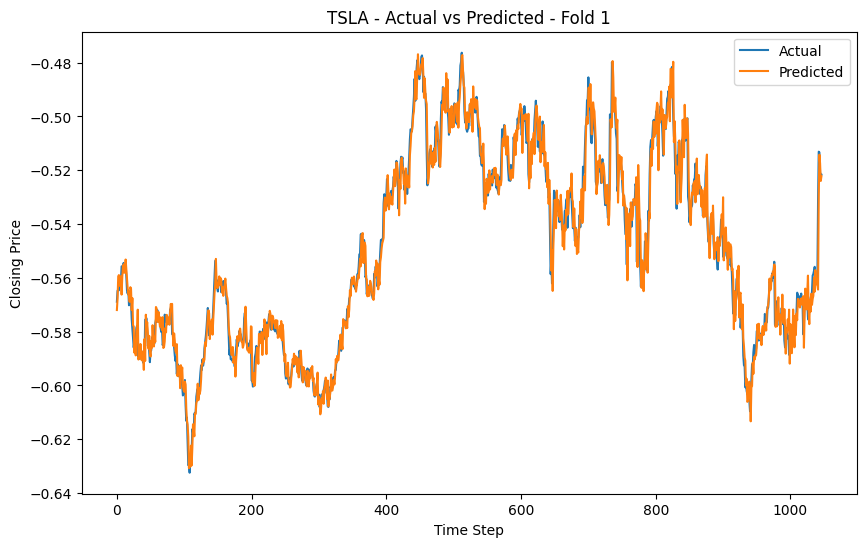

Fold 2...


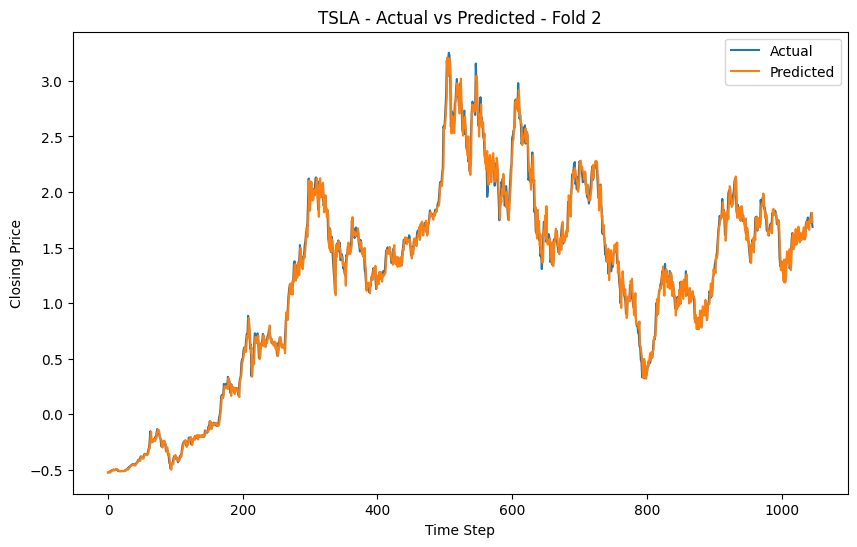

[*********************100%***********************]  1 of 1 completed

Next Day's Predicted Price for TSLA on 2023-12-30: 242.75463595729258

Summary of Linear Regression Performance for TSLA:
  Ticker  Fold       MSE       MAE  R2 Score      MAPE
0   TSLA     1  0.000037  0.004352  0.971298  0.008030
1   TSLA     2  0.007827  0.062876  0.990051  0.098085

Overall Metrics for TSLA:
Mean Squared Error: 0.00393202328122336
Mean Absolute Error: 0.03361392284023627
R2 Score: 0.9966922352864839
Mean Absolute Percentage Error (MAPE): 0.05305736941574911
Processing SBIN.NS...
Fold 1...


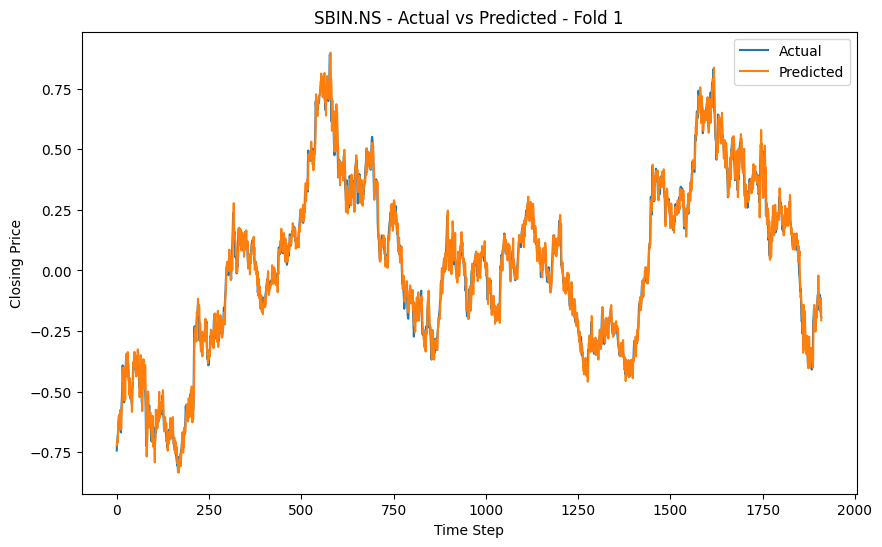

Fold 2...


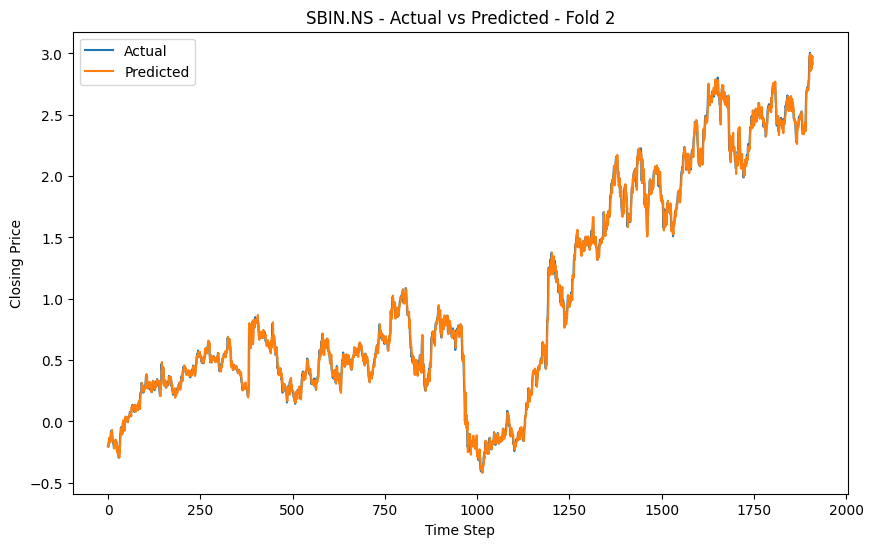

[*********************100%***********************]  1 of 1 completed

Next Day's Predicted Price for SBIN.NS on 2023-12-30: 641.620163079588

Summary of Linear Regression Performance for SBIN.NS:
    Ticker  Fold       MSE       MAE  R2 Score      MAPE
0  SBIN.NS     1  0.001729  0.032062  0.985781  0.707101
1  SBIN.NS     2  0.002425  0.035456  0.996939  0.211039

Overall Metrics for SBIN.NS:
Mean Squared Error: 0.002076995923543655
Mean Absolute Error: 0.033759146033913015
R2 Score: 0.9970034216337971
Mean Absolute Percentage Error (MAPE): 0.4590697545696775
Processing INFY.NS...
Fold 1...


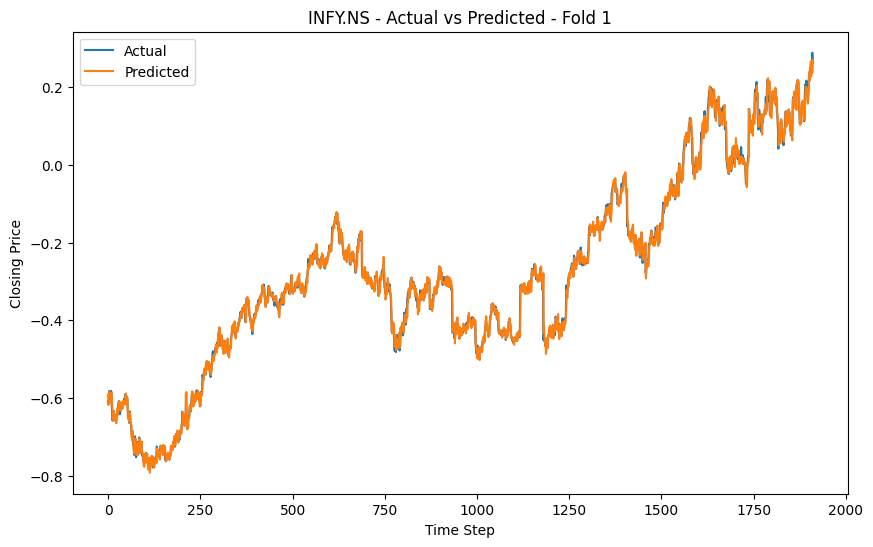

Fold 2...


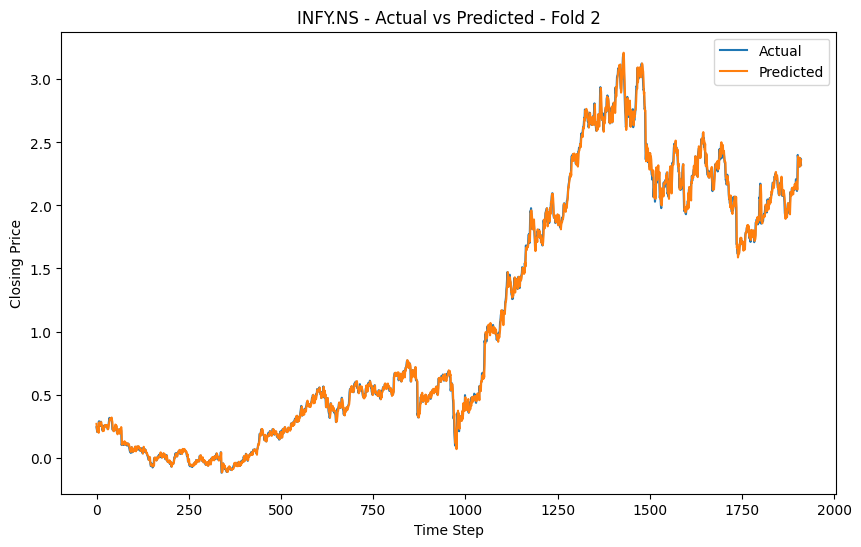

Next Day's Predicted Price for INFY.NS on 2023-12-30: 1543.3348814774567

Summary of Linear Regression Performance for INFY.NS:
    Ticker  Fold       MSE       MAE  R2 Score      MAPE
0  INFY.NS     1  0.000275  0.011817  0.995440  0.214947
1  INFY.NS     2  0.001600  0.027088  0.998375  0.229957

Overall Metrics for INFY.NS:
Mean Squared Error: 0.0009375242193389618
Mean Absolute Error: 0.01945235782304661
R2 Score: 0.9990651421265542
Mean Absolute Percentage Error (MAPE): 0.2224517370451968

Summary of Linear Regression Performance for All Stocks (Including Next Day Predictions):
    Ticker  Fold       MSE       MAE  R2 Score      MAPE  Next Day Prediction  \
0     AAPL     1  0.000058  0.005315  0.997814  0.021272           190.902188   
1     AAPL     2  0.001700  0.026602  0.998526  0.114335           190.902188   
2     TSLA     1  0.000037  0.004352  0.971298  0.008030           242.754636   
3     TSLA     2  0.007827  0.062876  0.990051  0.098085           242.754636   
4  SB

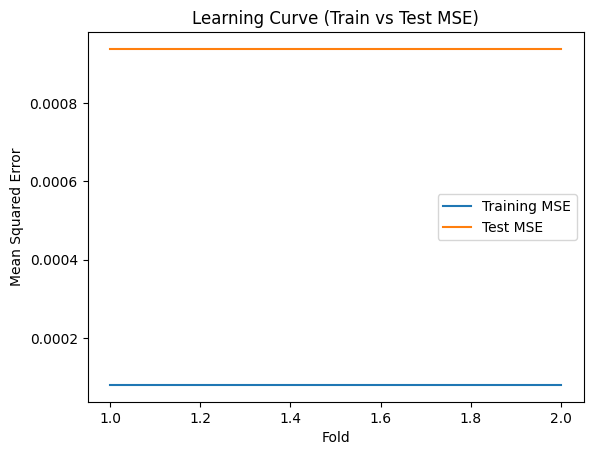

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta

# Ignore warnings (e.g., from scikit-learn)
warnings.filterwarnings('ignore')

# Load stock data from Yahoo Finance
tickers = ['AAPL', 'TSLA', 'SBIN.NS', 'INFY.NS']  # Add more stocks here if needed
start_date = '2000-01-01'
end_date = '2024-01-01'

# Store results for all stocks
all_results = []

# Function to create sequences for time series prediction
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Input data (last 60 time steps)
        y.append(data[i, 0])  # Predicting the closing price
    return np.array(X), np.array(y)

# Loop through all tickers
for ticker in tickers:
    print(f"Processing {ticker}...")

    # Load stock data
    df = yf.download(ticker, start=start_date, end=end_date)

    # Feature Engineering: Add Moving Averages and other indicators
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()

    # Drop NA values
    df = df.dropna()

    # Feature selection (adding more features like MACD, RSI)
    features = ['Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])

    # Create sequences for time series prediction
    sequence_length = 60  # Use 60 time steps
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeries Split for cross-validation (2 folds)
    tscv = TimeSeriesSplit(n_splits=2)

    # Initialize variables to store results
    results = []
    y_true_all = []
    y_pred_all = []
    train_mse_all = []
    train_mae_all = []
    train_r2_all = []
    test_mse_all = []
    test_mae_all = []
    test_r2_all = []

    # Initialize variable to store the next day prediction
    next_day_prediction = None
    next_day_date = None

    # Loop through the cross-validation folds
    for fold, (train_index, test_index) in enumerate(tscv.split(X, y)):
        print(f"Fold {fold + 1}...")

        # Split data into training and testing for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build the Linear Regression model
        model = LinearRegression()

        # Train the model
        model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshaping X_train for Linear Regression

        # Predict using the trained model
        y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshaping X_test for Linear Regression

        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Store results for each fold
        results.append([ticker, fold + 1, mse, mae, r2, mape])

        # Store true and predicted values for later use
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Store training metrics
        train_mse = mean_squared_error(y_train, model.predict(X_train.reshape(X_train.shape[0], -1)))
        train_mae = mean_absolute_error(y_train, model.predict(X_train.reshape(X_train.shape[0], -1)))
        train_r2 = r2_score(y_train, model.predict(X_train.reshape(X_train.shape[0], -1)))

        train_mse_all.append(train_mse)
        train_mae_all.append(train_mae)
        train_r2_all.append(train_r2)

        # Store test metrics
        test_mse_all.append(mse)
        test_mae_all.append(mae)
        test_r2_all.append(r2)

        # Plot Actual vs Predicted for each fold
        plt.figure(figsize=(10,6))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.title(f'{ticker} - Actual vs Predicted - Fold {fold + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()

    # Make prediction for the next day after the last date in the dataset
    last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, len(features))  # Reshaping for LSTM-like input
    next_day_pred = model.predict(last_sequence.reshape(last_sequence.shape[0], -1))

    # Get the next day's date
    last_date = df.index[-1]
    next_day_date = last_date + timedelta(days=1)

    # Denormalize the predicted value (if necessary)
    next_day_pred_value = scaler.inverse_transform(np.concatenate((next_day_pred.reshape(-1, 1), np.zeros((len(next_day_pred), len(features)-1))), axis=1))[:, 0]

    # Store the next day's predicted value in the results
    next_day_prediction = next_day_pred_value[0]

    print(f"Next Day's Predicted Price for {ticker} on {next_day_date.strftime('%Y-%m-%d')}: {next_day_prediction}")

    # Create a DataFrame for results for this ticker
    results_df = pd.DataFrame(results, columns=['Ticker', 'Fold', 'MSE', 'MAE', 'R2 Score', 'MAPE'])
    all_results.append(results_df)

    # Print results summary for the ticker
    print(f"\nSummary of Linear Regression Performance for {ticker}:")
    print(results_df)

    # Calculate overall metrics for the ticker
    overall_mse = mean_squared_error(y_true_all, y_pred_all)
    overall_mae = mean_absolute_error(y_true_all, y_pred_all)
    overall_r2 = r2_score(y_true_all, y_pred_all)
    overall_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)

    print(f"\nOverall Metrics for {ticker}:")
    print(f"Mean Squared Error: {overall_mse}")
    print(f"Mean Absolute Error: {overall_mae}")
    print(f"R2 Score: {overall_r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {overall_mape}")

    # Add the next day's prediction to the summary table
    results_df['Next Day Prediction'] = next_day_prediction
    results_df['Next Day Date'] = next_day_date.strftime('%Y-%m-%d')

# Combine results for all tickers into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Print the combined summary with next day predictions
print("\nSummary of Linear Regression Performance for All Stocks (Including Next Day Predictions):")
print(all_results_df)

# Plot the learning curve for the final model
# Compute the mean across folds for MSE values
mean_train_mse = np.mean(train_mse_all)
mean_test_mse = np.mean(test_mse_all)

# Plot MSE
plt.plot(range(1, len(train_mse_all) + 1), [mean_train_mse] * len(train_mse_all), label='Training MSE')
plt.plot(range(1, len(test_mse_all) + 1), [mean_test_mse] * len(test_mse_all), label='Test MSE')
plt.legend()
plt.title('Learning Curve (Train vs Test MSE)')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.show()


Processing AAPL...


[*********************100%***********************]  1 of 1 completed


Fold 1...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


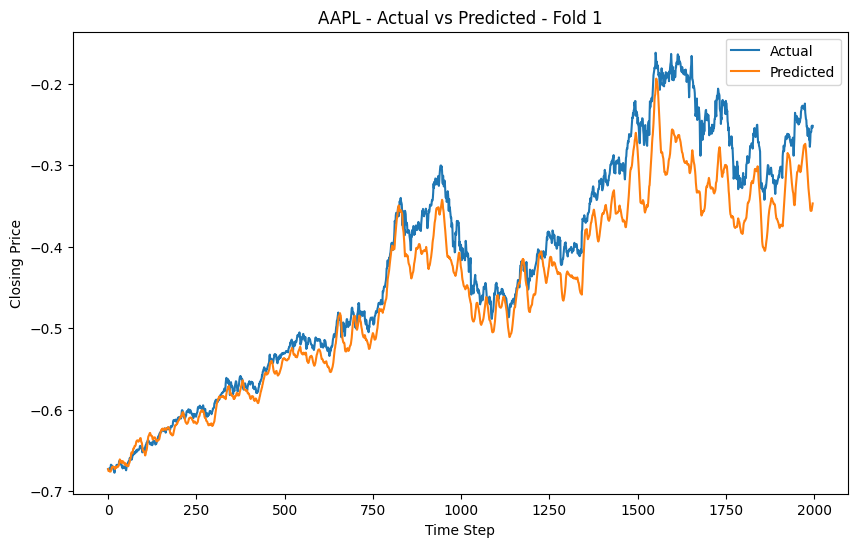

Fold 2...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


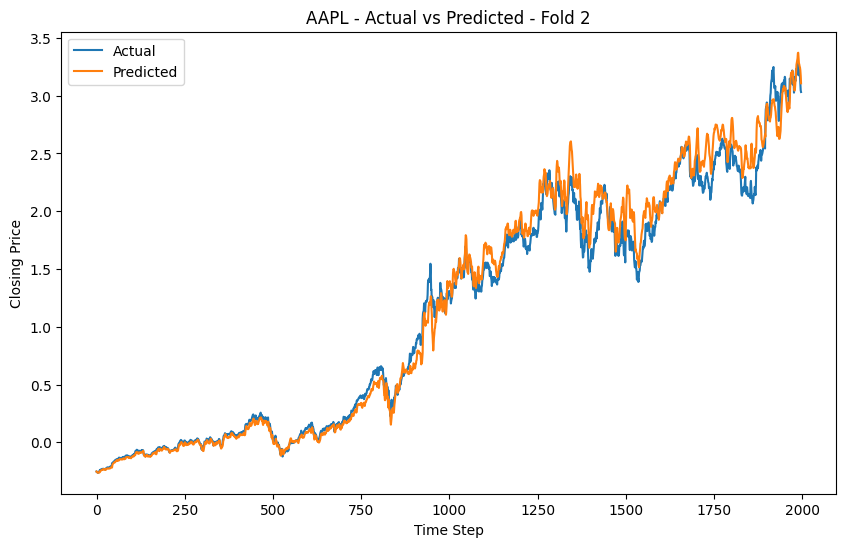

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Next Day's Predicted Price for AAPL on 2024-11-05: 223.4934111234896

Summary of Performance for AAPL:
  Ticker  Fold       MSE       MAE  R2 Score      MAPE
0   AAPL     1  0.002035  0.034528  0.894691  0.118740
1   AAPL     2  0.017894  0.092806  0.982882  0.391908

Overall Metrics for AAPL:
Mean Squared Error: 0.009964560615405495
Mean Absolute Error: 0.06366688120392107
R2 Score: 0.9912597375106901
Mean Absolute Percentage Error (MAPE): 0.2553239131158532
Processing TSLA...


[*********************100%***********************]  1 of 1 completed


Fold 1...
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


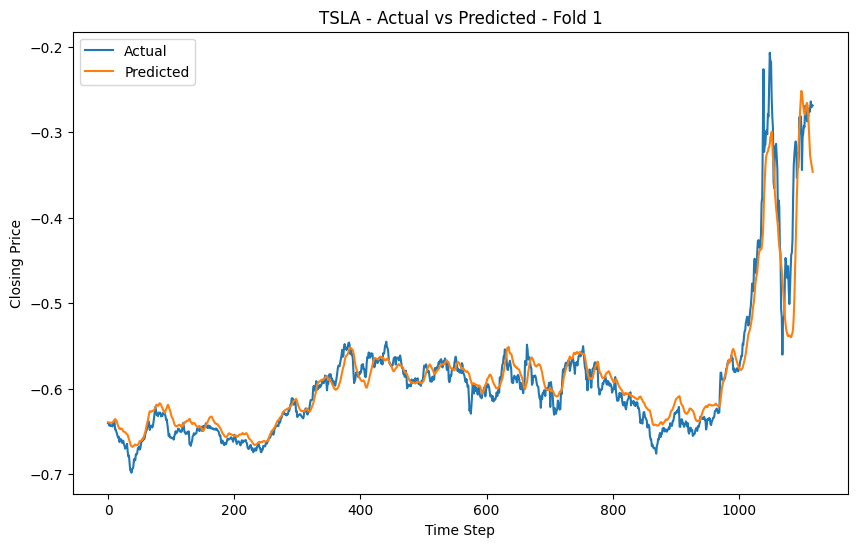

Fold 2...
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


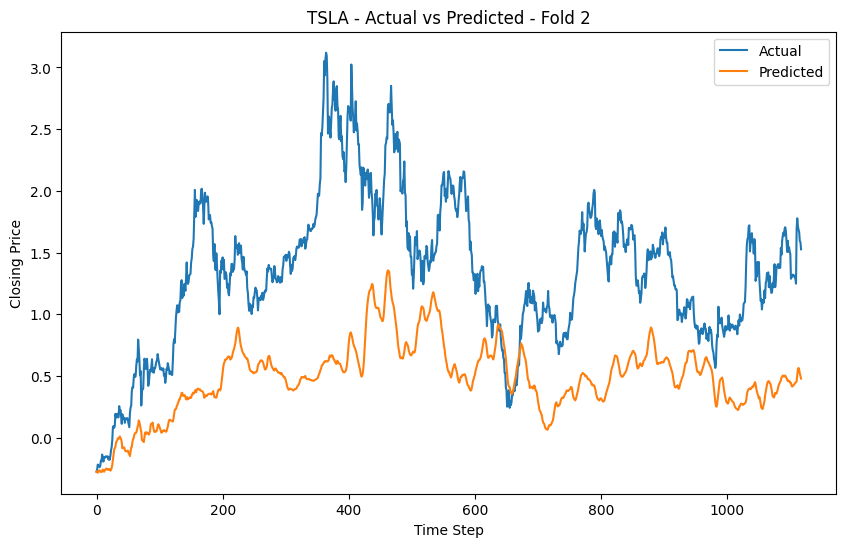

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Next Day's Predicted Price for TSLA on 2024-11-05: 130.05118812892232

Summary of Performance for TSLA:
  Ticker  Fold       MSE       MAE  R2 Score      MAPE
0   TSLA     1  0.000521  0.014215  0.923736  0.029156
1   TSLA     2  0.954714  0.853335 -1.541433  0.651522

Overall Metrics for TSLA:
Mean Squared Error: 0.47761791371272905
Mean Absolute Error: 0.43377529985341473
R2 Score: 0.5740080336772209
Mean Absolute Percentage Error (MAPE): 0.3403387618300439
Processing SBIN.NS...


[*********************100%***********************]  1 of 1 completed


Fold 1...
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


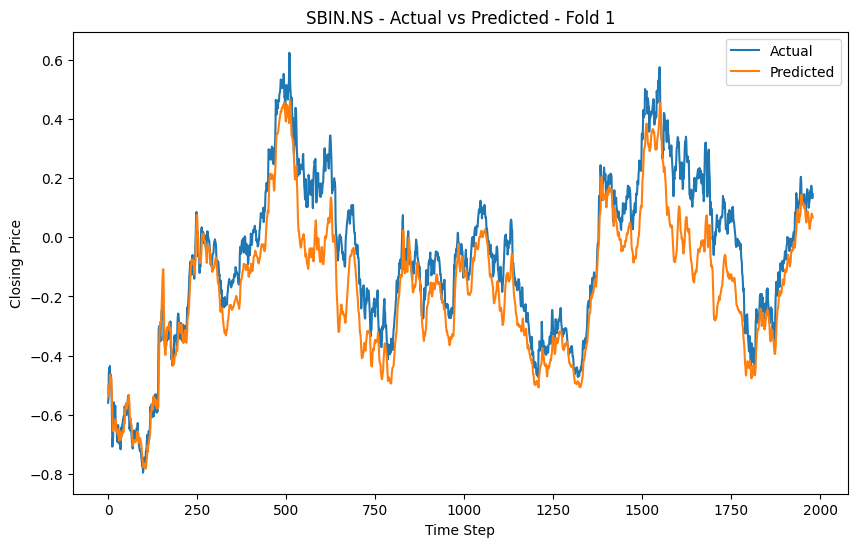

Fold 2...
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


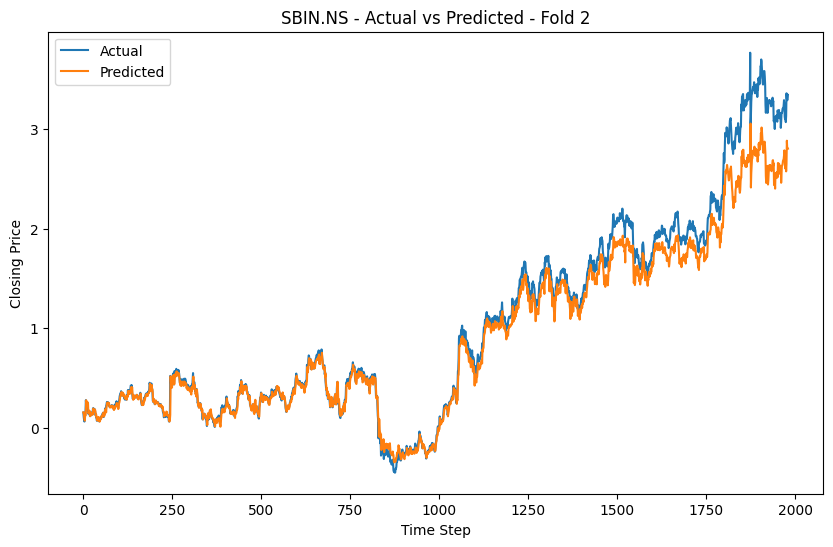

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Next Day's Predicted Price for SBIN.NS on 2024-11-05: 743.5652047409553

Summary of Performance for SBIN.NS:
    Ticker  Fold       MSE       MAE  R2 Score       MAPE
0  SBIN.NS     1  0.015901  0.100840  0.788496  31.531528
1  SBIN.NS     2  0.041990  0.121378  0.957601   0.180855

Overall Metrics for SBIN.NS:
Mean Squared Error: 0.02894510517976541
Mean Absolute Error: 0.11110937475497053
R2 Score: 0.9649871434879217
Mean Absolute Percentage Error (MAPE): 15.856191548168406
Processing INFY.NS...


[*********************100%***********************]  1 of 1 completed


Fold 1...
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


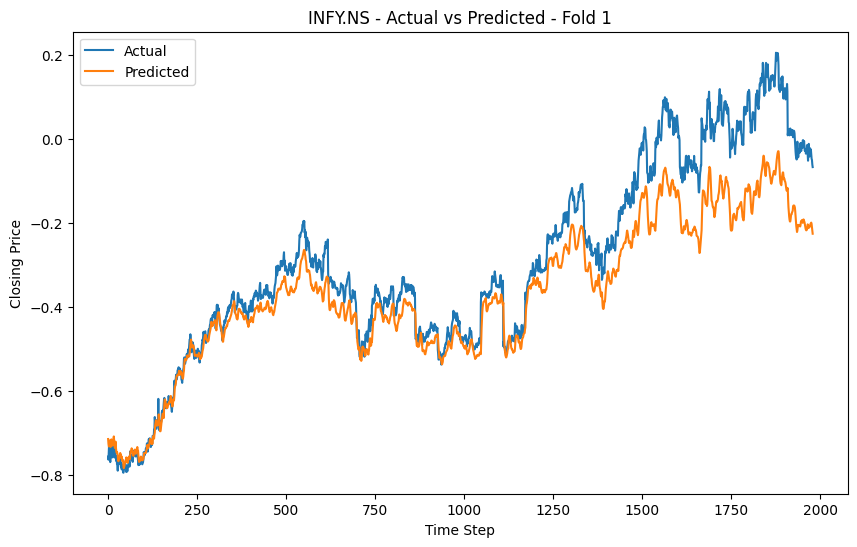

Fold 2...
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


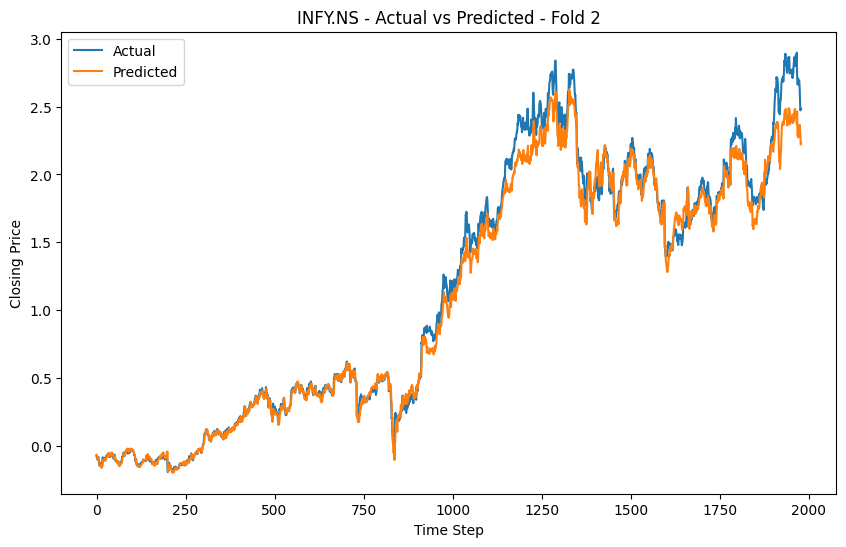

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Next Day's Predicted Price for INFY.NS on 2024-11-05: 1632.8926062331234

Summary of Performance for INFY.NS:
    Ticker  Fold       MSE       MAE  R2 Score      MAPE
0  INFY.NS     1  0.009834  0.073269  0.821344  2.533049
1  INFY.NS     2  0.013173  0.075001  0.985506  0.088871

Overall Metrics for INFY.NS:
Mean Squared Error: 0.01150309428231556
Mean Absolute Error: 0.07413517891138653
R2 Score: 0.9884344632411052
Mean Absolute Percentage Error (MAPE): 1.3109598746184732

Summary of Performance for All Stocks (Including Next Day Predictions):
    Ticker  Fold       MSE       MAE  R2 Score       MAPE  \
0     AAPL     1  0.002035  0.034528  0.894691   0.118740   
1     AAPL     2  0.017894  0.092806  0.982882   0.391908   
2     TSLA     1  0.000521  0.014215  0.923736   0.029156   
3     TSLA     2  0.954714  0.853335 -1.541433   0.651522   
4  SBIN.NS     1  0.015901  0.100840  0.788496  31.531528   
5  SBIN.NS     2  0.041990  0.121378  0.9576

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
import matplotlib.pyplot as plt
import warnings

# Ignore warnings (e.g., from TensorFlow or scikit-learn)
warnings.filterwarnings('ignore')

# Load stock data from Yahoo Finance
tickers = ['AAPL', 'TSLA', 'SBIN.NS', 'INFY.NS']  # Add more stocks here if needed
start_date = '2000-01-01'
end_date = '2024-11-05'

# Store results for all stocks
all_results = []

# Function to create sequences for time series prediction
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Input data (last 60 time steps)
        y.append(data[i, 0])  # Predicting the closing price
    return np.array(X), np.array(y)

# Loop through all tickers
for ticker in tickers:
    print(f"Processing {ticker}...")

    # Load stock data
    df = yf.download(ticker, start=start_date, end=end_date)

    # Feature Engineering: Add Moving Averages and other indicators
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(window=14).mean()))
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()

    # Drop NA values
    df = df.dropna()

    # Feature selection (adding more features like MACD, RSI)
    features = ['Close', 'SMA_50', 'SMA_200', 'RSI', 'MACD']

    # Normalize features using StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features])

    # Create sequences for time series prediction
    sequence_length = 60  # Use 60 time steps
    X, y = create_sequences(scaled_data, sequence_length)

    # TimeSeries Split for cross-validation (2 folds)
    tscv = TimeSeriesSplit(n_splits=2)

    # Initialize variables to store results
    results = []
    y_true_all = []
    y_pred_all = []
    train_mse_all = []
    train_mae_all = []
    train_r2_all = []
    test_mse_all = []
    test_mae_all = []
    test_r2_all = []

    # Loop through the cross-validation folds
    for fold, (train_index, test_index) in enumerate(tscv.split(X, y)):
        print(f"Fold {fold + 1}...")

        # Split data into training and testing for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build the BiLSTM model
        model = Sequential()
        model.add(Bidirectional(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]))))
        model.add(Dropout(0.2))  # Dropout to prevent overfitting
        model.add(Dense(units=1))  # Output layer (predicted closing price)

        # Compile and train the model (100 epochs)
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)  # Changed epochs to 100

        # Predict using the trained model
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Store results for each fold
        results.append([ticker, fold + 1, mse, mae, r2, mape])

        # Store true and predicted values for later use
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Store training metrics
        train_mse = mean_squared_error(y_train, model.predict(X_train))
        train_mae = mean_absolute_error(y_train, model.predict(X_train))
        train_r2 = r2_score(y_train, model.predict(X_train))

        train_mse_all.append(train_mse)
        train_mae_all.append(train_mae)
        train_r2_all.append(train_r2)

        # Store test metrics
        test_mse_all.append(mse)
        test_mae_all.append(mae)
        test_r2_all.append(r2)

        # Plot Actual vs Predicted for each fold
        plt.figure(figsize=(10,6))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred.flatten(), label='Predicted')
        plt.title(f'{ticker} - Actual vs Predicted - Fold {fold + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()

    # Make prediction for the next day after the last date in the dataset
    last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, len(features))  # Reshaping for LSTM-like input
    next_day_pred = model.predict(last_sequence)

    # Get the next day's date
    last_date = df.index[-1]
    next_day_date = last_date + pd.Timedelta(days=1)

    # Denormalize the predicted value (if necessary)
    next_day_pred_value = scaler.inverse_transform(np.concatenate((next_day_pred.reshape(-1, 1), np.zeros((len(next_day_pred), len(features)-1))), axis=1))[:, 0]

    # Store the next day's predicted value in the results
    next_day_prediction = next_day_pred_value[0]

    print(f"Next Day's Predicted Price for {ticker} on {next_day_date.strftime('%Y-%m-%d')}: {next_day_prediction}")

    # Create a DataFrame for results for this ticker
    results_df = pd.DataFrame(results, columns=['Ticker', 'Fold', 'MSE', 'MAE', 'R2 Score', 'MAPE'])
    all_results.append(results_df)

    # Print results summary for the ticker
    print(f"\nSummary of Performance for {ticker}:")
    print(results_df)

    # Calculate overall metrics for the ticker
    overall_mse = mean_squared_error(y_true_all, y_pred_all)
    overall_mae = mean_absolute_error(y_true_all, y_pred_all)
    overall_r2 = r2_score(y_true_all, y_pred_all)
    overall_mape = mean_absolute_percentage_error(y_true_all, y_pred_all)

    print(f"\nOverall Metrics for {ticker}:")
    print(f"Mean Squared Error: {overall_mse}")
    print(f"Mean Absolute Error: {overall_mae}")
    print(f"R2 Score: {overall_r2}")
    print(f"Mean Absolute Percentage Error (MAPE): {overall_mape}")

    # Add the next day's prediction to the summary table
    results_df['Next Day Prediction'] = next_day_prediction
    results_df['Next Day Date'] = next_day_date.strftime('%Y-%m-%d')

# Combine results for all tickers into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Print the combined summary
print("\nSummary of Performance for All Stocks (Including Next Day Predictions):")
print(all_results_df)
